In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from collections import defaultdict
import random
import re


In [2]:
# 1. Prepare corpus
corpus = "I love machine learning. Machine learning is fun and exciting".lower().split()

# 2. Build vocabulary
vocab = set(corpus)
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)

# 3. Generate training data (skip-gram, window size = 2)
def generate_training_data(corpus, window_size):
    training_data = []
    for idx, center_word in enumerate(corpus):
        for w in range(-window_size, window_size + 1):
            context_pos = idx + w
            if context_pos < 0 or context_pos >= len(corpus) or context_pos == idx:
                continue
            context_word = corpus[context_pos]
            training_data.append((word_to_idx[center_word], word_to_idx[context_word]))
    return training_data

training_data = generate_training_data(corpus, window_size=2)

# 4. Initialize weights
embedding_size = 10  # small size for illustration
W1 = np.random.rand(vocab_size, embedding_size)  # input -> hidden
W2 = np.random.rand(embedding_size, vocab_size)  # hidden -> output

# 5. Training parameters
epochs = 1000
learning_rate = 0.01

# 6. One-hot encoding helper
def one_hot_vector(word_idx, vocab_size):
    vec = np.zeros(vocab_size)
    vec[word_idx] = 1
    return vec

# 7. Training loop
for epoch in range(epochs):
    loss = 0
    for center_idx, context_idx in training_data:
        # Step 1: forward pass
        x = one_hot_vector(center_idx, vocab_size)  # one-hot vector for center word
        hidden = np.dot(x, W1)                      # hidden layer
        output = np.dot(hidden, W2)                 # raw scores
        y_pred = np.exp(output) / np.sum(np.exp(output))  # softmax

        # Step 2: calculate loss (cross-entropy)
        y_true = one_hot_vector(context_idx, vocab_size)
        loss -= np.log(y_pred[context_idx])

        # Step 3: backpropagation
        e = y_pred - y_true  # error at output layer

        # gradients
        dW2 = np.outer(hidden, e)
        dW1 = np.outer(x, np.dot(W2, e))

        # update weights
        W1 -= learning_rate * dW1
        W2 -= learning_rate * dW2

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

# 8. Extract word embeddings
def get_embedding(word):
    word_idx = word_to_idx[word]
    return W1[word_idx]

# Example: get vector for 'machine'
print("\nVector for 'machine':\n", get_embedding('machine'))

# Similarity function
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Test similarity
print("\nSimilarity between 'machine' and 'learning':")
print(cosine_similarity(get_embedding('machine'), get_embedding('learning')))


Epoch 0, Loss: 76.0632
Epoch 100, Loss: 52.2637
Epoch 200, Loss: 46.8429
Epoch 300, Loss: 46.0625
Epoch 400, Loss: 45.8529
Epoch 500, Loss: 45.7756
Epoch 600, Loss: 45.7423
Epoch 700, Loss: 45.7265
Epoch 800, Loss: 45.7184
Epoch 900, Loss: 45.7140

Vector for 'machine':
 [ 0.23081623  0.55475964  0.94913858 -0.1938787   0.52058287 -0.8853882
  0.88851028  0.61100656 -0.67253818  0.67719517]

Similarity between 'machine' and 'learning':
0.3642581307281046


In [5]:


class Word2VecNegativeSampling:
    def __init__(self, corpus, window_size=2, embedding_size=50, epochs=1000, learning_rate=0.01, negative_samples=5):
        self.window_size = window_size
        self.embedding_size = embedding_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.negative_samples = negative_samples
        self.corpus = self._preprocess(corpus)
        self.build_vocab()
        self.generate_training_data()
        self.initialize_weights()

    def _preprocess(self, text):
        text = re.sub(r'[^\w\s]', '', text.lower())  # remove punctuation
        return text.split()

    def build_vocab(self):
        self.vocab = set(self.corpus)
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        self.idx_to_word = {idx: word for word, idx in self.word_to_idx.items()}
        self.vocab_size = len(self.vocab)
        self.word_freq = defaultdict(int)
        for word in self.corpus:
            self.word_freq[word] += 1

    def generate_training_data(self):
        self.training_data = []
        for idx, center_word in enumerate(self.corpus):
            center_idx = self.word_to_idx[center_word]
            for w in range(-self.window_size, self.window_size + 1):
                context_pos = idx + w
                if context_pos < 0 or context_pos >= len(self.corpus) or context_pos == idx:
                    continue
                context_word = self.corpus[context_pos]
                context_idx = self.word_to_idx[context_word]
                self.training_data.append((center_idx, context_idx))

    def initialize_weights(self):
        self.W1 = np.random.randn(self.vocab_size, self.embedding_size) * 0.01
        self.W2 = np.random.randn(self.vocab_size, self.embedding_size) * 0.01

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def get_negative_samples(self, true_idx):
        negatives = set()
        while len(negatives) < self.negative_samples:
            idx = random.randint(0, self.vocab_size - 1)
            if idx != true_idx:
                negatives.add(idx)
        return list(negatives)

    def train(self):
        for epoch in range(self.epochs):
            loss = 0
            for center_idx, context_idx in self.training_data:
                v_c = self.W1[center_idx]
                u_o = self.W2[context_idx]

                # Positive sample
                score = self.sigmoid(np.dot(u_o, v_c))
                grad_loss = 1 - score

                self.W2[context_idx] += self.learning_rate * grad_loss * v_c
                self.W1[center_idx] += self.learning_rate * grad_loss * u_o
                loss += -np.log(score + 1e-9)

                # Negative samples
                for neg_idx in self.get_negative_samples(context_idx):
                    u_k = self.W2[neg_idx]
                    score_neg = self.sigmoid(-np.dot(u_k, v_c))
                    grad_loss_neg = 1 - score_neg

                    self.W2[neg_idx] -= self.learning_rate * grad_loss_neg * v_c
                    self.W1[center_idx] -= self.learning_rate * grad_loss_neg * u_k
                    loss += -np.log(score_neg + 1e-9)

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def get_embedding(self, word):
        return self.W1[self.word_to_idx[word]]

    def most_similar(self, word, top_n=5):
        vec = self.get_embedding(word)
        similarities = []
        for other_word in self.vocab:
            if other_word == word:
                continue
            other_vec = self.get_embedding(other_word)
            cos_sim = np.dot(vec, other_vec) / (np.linalg.norm(vec) * np.linalg.norm(other_vec))
            similarities.append((other_word, cos_sim))
        similarities.sort(key=lambda x: x[1], reverse=True)
        return similarities[:top_n]

    def visualize_embeddings(self):
        pca = PCA(n_components=2)
        reduced = pca.fit_transform(self.W1)
        plt.figure(figsize=(12, 8))
        for i, word in enumerate(self.vocab):
            x, y = reduced[i]
            plt.scatter(x, y)
            plt.annotate(word, (x, y))
        plt.title("Word2Vec (Negative Sampling) Embeddings Visualized (PCA)")
        plt.show()


Epoch 0, Loss: 806.8214
Epoch 100, Loss: 512.8992
Epoch 200, Loss: 307.6357
Epoch 300, Loss: 232.3012
Epoch 400, Loss: 210.8933
Similar to 'machine': [('intelligence', np.float64(0.7042644652411286)), ('the', np.float64(0.6919132134479803)), ('build', np.float64(0.6914728073657875)), ('learning', np.float64(0.6210211521232705)), ('of', np.float64(0.6110084502581793))]
Similar to 'learning': [('artificial', np.float64(0.6881435950368325)), ('machine', np.float64(0.6210211521232705)), ('study', np.float64(0.6064563958758813)), ('model', np.float64(0.537359404706994)), ('is', np.float64(0.5108912048691963))]


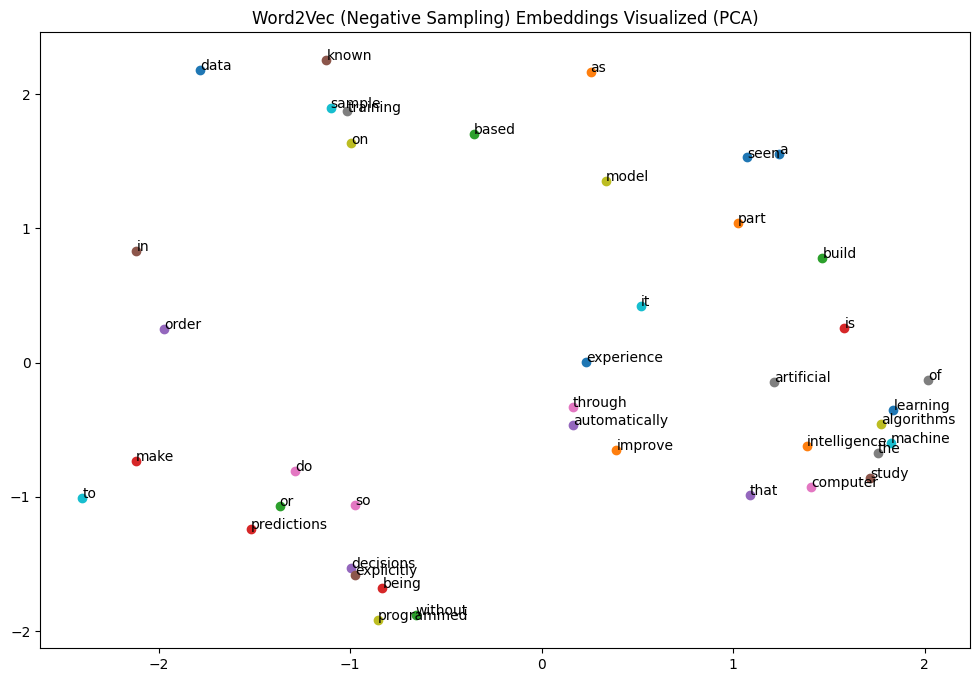

In [6]:
text = """
Machine learning is the study of computer algorithms that improve automatically through experience.
It is seen as a part of artificial intelligence. Machine learning algorithms build a model based on sample data,
known as training data, in order to make predictions or decisions without being explicitly programmed to do so.
"""

w2v = Word2VecNegativeSampling(corpus=text, embedding_size=20, epochs=500)
w2v.train()

print("Similar to 'machine':", w2v.most_similar('machine'))
print("Similar to 'learning':", w2v.most_similar('learning'))

w2v.visualize_embeddings()
